In [1]:
from interaction_inference import simulation, dataset, optimization
import numpy as np
import pandas as pd

# Validation table

Validate the model feasiblity tests by simulating a sample from each model and testing the feasiblity under each set of constraints to build a table that should match expected results.

Consider the models:

- independent birth-death
- interacting birth-death
- independent telegraph
- interacting telegraph

And the situations where: telegraph data is identifiably different from birth-death data (i.e. gene is off sometimes), and also where it is not (i.e. gene almost always on)

In [2]:
def simulate_dataset(on_rate=0.5, off_rate=0.5, tx_rate=5, int_str=10, cells=1000):

    # independent birth-death model
    ind_BD_params = {
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': 0
    }

    # interacting birth-death model
    int_BD_params = {
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': int_str
    }

    # independent telegraph model
    ind_TE_params = {
        'k_on_1': on_rate,
        'k_on_2': on_rate,
        'k_off_1': off_rate,
        'k_off_2': off_rate,
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': 0
    }

    # interacting telegraph model
    int_TE_params = {
        'k_on_1': on_rate,
        'k_on_2': on_rate,
        'k_off_1': off_rate,
        'k_off_2': off_rate,
        'k_tx_1': tx_rate,
        'k_tx_2': tx_rate,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg': int_str
    }

    # dataframe
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(4)], columns=[f"Cell-{j}" for j in range(cells)])

    # simulate
    counts_df.iloc[0] = simulation.gillespie_birth_death(ind_BD_params, cells)
    counts_df.iloc[1] = simulation.gillespie_birth_death(int_BD_params, cells)
    counts_df.iloc[2] = simulation.gillespie_telegraph(ind_TE_params, cells)
    counts_df.iloc[3] = simulation.gillespie_telegraph(int_TE_params, cells)

    # construct dataset object
    data = dataset.Dataset("table")

    # store information
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = 4
    data.beta = np.array([1.0 for j in range(cells)])

    # bootstrap
    data.bootstrap_marginal_fm(tqdm_disable=False)
    data.bootstrap_joint_fm(tqdm_disable=False)
    data.bootstrap_marginal_probabilities(tqdm_disable=False)
    data.bootstrap_joint_probabilities(tqdm_disable=False)

    return data

In [3]:
def result_format(opt):
    result = []
    for res in opt.result_dict.values():
        if res['status'] == "OPTIMAL":
            result.append("FEASIBLE")
        elif res['status'] == "INFEASIBLE":
            result.append("INFEASIBLE")
        else:
            result.append("ERROR")
    return result

def _color_red_or_green(val):
    if val == "FEASIBLE":
        color = 'green'
    elif val == "INFEASIBLE":
        color = 'red'
    else:
        color = 'white'
    return 'color: %s' % color

In [4]:
def optimize_dataset_downsampled(data):

    ind_BD_constraints = [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_1",
        "downsampled_marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ]

    ind_BD_optimization = optimization.Optimization(data, ind_BD_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    int_BD_constraints = [
        "downsampled_probability",
        "downsampled_CME",
        "k_deg_1"
    ]

    int_BD_optimization = optimization.Optimization(data, int_BD_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    ind_TE_constraints = [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_CME_TE_2",
        "downsampled_marginal_TE_link_1",
        "downsampled_marginal_TE_link_2"
        "k_deg_1",
        "k_deg_2"
    ]

    ind_TE_optimization = optimization.Optimization(data, ind_TE_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    int_TE_constraints = [
        "downsampled_probability",
        "downsampled_CME_TE",
        "downsampled_TE_link",
        "k_deg_1"
    ]

    int_TE_optimization = optimization.Optimization(data, int_TE_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    # result dataframe
    col_names = ["Ind. BD model", "Int. BD model", "Ind. TE model", "Int. TE model"]
    row_names = ["Ind. BD data", "Int. BD data", "Ind. TE data", "Int. TE data"]
    result_df = pd.DataFrame(index=row_names, columns=col_names)

    # fill
    result_df["Ind. BD model"] = result_format(ind_BD_optimization)
    result_df["Int. BD model"] = result_format(int_BD_optimization)
    result_df["Ind. TE model"] = result_format(ind_TE_optimization)
    result_df["Int. TE model"] = result_format(int_TE_optimization)

    return result_df.style.map(_color_red_or_green)

## BD $\ne$ TE data

In [29]:
data = simulate_dataset()

100%|██████████| 4/4 [00:00<00:00, 41.25it/s]


In [30]:
result = optimize_dataset_downsampled(data)

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


In [31]:
result

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE


## BD $\approx$ TE data

In [35]:
data = simulate_dataset(on_rate=0.95, off_rate=0.05)

100%|██████████| 4/4 [00:00<00:00, 18.77it/s]


In [36]:
result = optimize_dataset_downsampled(data)

100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


In [37]:
result

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE


Results not as expected:

- BD models perform mostly as expected, although when BD $\approx$ TE the Ind. BD model is very sensitive to non-poisson data, so independent telegraph data is still infeasible for off rate = 0.05
- TE models always remain feasible, even for high interaction data + Ind. TE model

# B-method

In [5]:
def optimize_dataset_B(data):

    data.compute_probabilities(display=True, tqdm_disable=False)

    ind_BD_constraints = [
        "marginal_probability_1",
        "marginal_probability_2",
        "marginal_CME_1",
        "marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ]

    ind_BD_optimization = optimization.Optimization(data, ind_BD_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    int_BD_constraints = [
        "joint_probability",
        "CME",
        "k_deg_1"
    ]

    int_BD_optimization = optimization.Optimization(data, int_BD_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    ind_TE_constraints = [
        "factorization",
        "probability",
        "marginal_probability_1",
        "marginal_probability_2",
        "marginal_CME_TE",
        "marginal_TE_equality",
        "k_deg_1",
        "k_deg_2"
    ]

    ind_TE_optimization = optimization.Optimization(data, ind_TE_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    int_TE_constraints = [
        "joint_probability",
        "CME_TE",
        "TE_equality",
        "k_deg_1"
    ]

    int_TE_optimization = optimization.Optimization(data, int_TE_constraints, tqdm_disable=False, print_solution=False, license_file="C:/WLS_credentials.json")

    # result dataframe
    col_names = ["Ind. BD model", "Int. BD model", "Ind. TE model", "Int. TE model"]
    row_names = ["Ind. BD data", "Int. BD data", "Ind. TE data", "Int. TE data"]
    result_df = pd.DataFrame(index=row_names, columns=col_names)

    # fill
    result_df["Ind. BD model"] = result_format(ind_BD_optimization)
    result_df["Int. BD model"] = result_format(int_BD_optimization)
    result_df["Ind. TE model"] = result_format(ind_TE_optimization)
    result_df["Int. TE model"] = result_format(int_TE_optimization)

    return result_df.style.map(_color_red_or_green)

In [6]:
data = simulate_dataset()

100%|██████████| 4/4 [00:00<00:00, 40.45it/s]


100%|██████████| 4/4 [00:00<00:00, 38.08it/s]


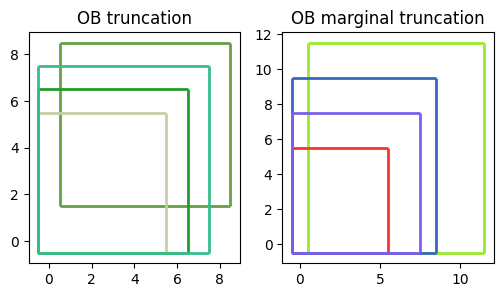

100%|██████████| 4/4 [00:22<00:00,  5.58s/it]


In [7]:
result = optimize_dataset_B(data)

In [8]:
result

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,INFEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,INFEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,INFEASIBLE,INFEASIBLE,FEASIBLE


In [12]:
data = simulate_dataset(on_rate=0.9, off_rate=0.1)

100%|██████████| 4/4 [00:00<00:00, 48.03it/s]


100%|██████████| 4/4 [00:00<00:00, 39.82it/s]


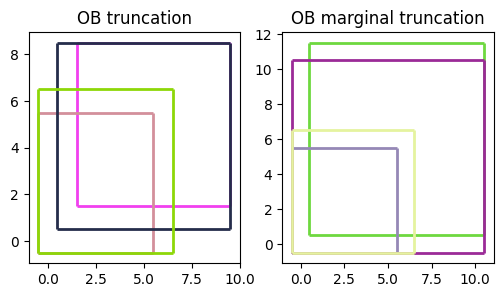

100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


In [13]:
result = optimize_dataset_B(data)

In [14]:
result

,Ind. BD model,Int. BD model,Ind. TE model,Int. TE model
Ind. BD data,FEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. BD data,INFEASIBLE,FEASIBLE,INFEASIBLE,FEASIBLE
Ind. TE data,INFEASIBLE,FEASIBLE,FEASIBLE,FEASIBLE
Int. TE data,INFEASIBLE,FEASIBLE,INFEASIBLE,FEASIBLE


Results almost as expected:

- when BE $\ne$ TE the models follow the expected results
- when BE $\approx$ TE the birth-death and telegraph models are almost identical, but the ind. BD model is very good a detecting non-poisson data and so is still infeasible for independent telegraph data even with off rate = 0.1

# Future 

___

Cannot use downsampled marginal CME for independent models, as correlation introduced by capture means they are not separable. Instead must use joint CME with $k_{reg} = 0$, and also cannot factorize downsampled joints due to this correlation.
___